## Test Diabetes dataset
- Document of dataset: 
    + https://archive.ics.uci.edu/dataset/34/diabetes
    + https://fairlearn.org/main/user_guide/datasets/diabetes_hospital_data.html
    + https://fairlearn.org/main/api_reference/generated/fairlearn.datasets.fetch_diabetes_hospital.html#fairlearn.datasets.fetch_diabetes_hospital


In [2]:
# Custom imports
# import my_helper # my helper functions
from TabResNet import TabResNet  # Import from existing script

# General imports
from IPython.display import Markdown, display, clear_output
from functools import partial
import pathlib
import numpy as np
import pandas as pd

# DL imports
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score
from sklearn.model_selection import train_test_split

# Choose the fairness metric
from fairlearn.metrics import (
    MetricFrame,
    count,
    false_negative_rate,
    false_positive_rate,
    selection_rate,
)

# Some "difference" metrics (as in Nils' paper)
# All ranges are [0,1] -> no need to scale 
from fairlearn.metrics import (
    demographic_parity_difference,
    equalized_odds_difference,
    true_positive_rate_difference,
    false_positive_rate_difference,
)

torch.manual_seed(27)
clear_output()
np.random.seed(27)

## Data Loading

In [3]:
# ---------------------------
# Data Loading and Preparation
# ---------------------------
from fairlearn.datasets import fetch_diabetes_hospital

# Data processing
X, y = fetch_diabetes_hospital(as_frame=True, return_X_y=True)
# The columns readmit_binary and readmitted are included in X -> remove both to avoid target leakage
X.drop(columns=["readmitted", "readmit_binary"], inplace=True)

In [4]:
y_df = pd.DataFrame(y)
print(y_df.value_counts(normalize=True))

readmit_30_days
0                  0.888401
1                  0.111599
Name: proportion, dtype: float64


## Data Preprocessing

### Remove Unknown/Invalid gender

In [5]:
# Get a boolean mask for rows where gender is not 'Unknown/Invalid' (which was encoded as 2)
valid_gender_mask = X['gender'] != 'Unknown/Invalid'

In [6]:
# Filter both X and y using the same mask
X = X[valid_gender_mask]
y = y[valid_gender_mask]

In [7]:
print("Remaining rows after removing 'Unknown/Invalid' gender values:")
print(X['gender'].value_counts())

Remaining rows after removing 'Unknown/Invalid' gender values:
gender
Female    54708
Male      47055
Name: count, dtype: int64


### Label Encoding

In [8]:
categorical_cols = X.select_dtypes(include=['object', 'category']).columns

In [9]:
from sklearn.preprocessing import LabelEncoder
label_mappings = {}
# Apply LabelEncoder to each column and store mappings
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_mappings[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Show mappings
for col, mapping in label_mappings.items():
    print(f"\nEncoded mapping for '{col}':")
    for original, encoded in mapping.items():
        print(f"  {original} → {encoded}")


Encoded mapping for 'race':
  AfricanAmerican → 0
  Asian → 1
  Caucasian → 2
  Hispanic → 3
  Other → 4
  Unknown → 5

Encoded mapping for 'gender':
  Female → 0
  Male → 1

Encoded mapping for 'age':
  '30 years or younger' → 0
  '30-60 years' → 1
  'Over 60 years' → 2

Encoded mapping for 'discharge_disposition_id':
  'Discharged to Home' → 0
  Other → 1

Encoded mapping for 'admission_source_id':
  Emergency → 0
  Other → 1
  Referral → 2

Encoded mapping for 'medical_specialty':
  Cardiology → 0
  Emergency/Trauma → 1
  Family/GeneralPractice → 2
  InternalMedicine → 3
  Missing → 4
  Other → 5

Encoded mapping for 'primary_diagnosis':
  'Genitourinary Issues' → 0
  'Musculoskeletal Issues' → 1
  'Respiratory Issues' → 2
  Diabetes → 3
  Other → 4

Encoded mapping for 'max_glu_serum':
  >200 → 0
  >300 → 1
  None → 2
  Norm → 3

Encoded mapping for 'A1Cresult':
  >7 → 0
  >8 → 1
  None → 2
  Norm → 3

Encoded mapping for 'insulin':
  Down → 0
  No → 1
  Steady → 2
  Up → 3

Encod

### Over-sampling imbalanced class

In [ ]:
from imblearn.over_sampling import SMOTE

# Apply SMOTE
smote = SMOTE(sampling_strategy=0.2, random_state=7)
X_smote, y_smote = smote.fit_resample(X, y)


In [17]:
y_smote_df = pd.DataFrame(y_smote)
print(y_smote_df.value_counts(normalize=True))

readmit_30_days
0                  0.800004
1                  0.199996
Name: proportion, dtype: float64


In [18]:
X_le = X_smote.drop(columns=["gender"])

### Data Splitting & Formatting

In [40]:
random_state = 7
X_train, X_test, y_train, y_test, A_train, A_test = train_test_split(
    X_le, y_smote, X_smote["gender"], test_size=0.2, random_state=random_state
)

In [42]:
print("Shape of X_train: ", X_train.shape)
print("Shape of y_train: ", y_train.shape)
print("Shape of A_train: ", A_train.shape)
print("Shape of A_test: ", A_test.shape)
print("Shape of X_test: ", X_test.shape)
print("Shape of y_test: ", y_test.shape)

Shape of X_train:  (90405, 21)
Shape of y_train:  (90405,)
Shape of A_train:  (90405,)
Shape of A_test:  (22602,)
Shape of X_test:  (22602, 21)
Shape of y_test:  (22602,)


In [43]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)

# Convert all data to integers -> avoid errors in training
y_train_np = y_train.astype(np.int64).values if isinstance(y_train, pd.Series) else y_train.astype(np.int64)
y_test_np = y_test.astype(np.int64).values if isinstance(y_test, pd.Series) else y_test.astype(np.int64)


# Convert data to tensors
X_train_tensor = torch.from_numpy(X_train_np)
y_train_tensor = torch.from_numpy(y_train_np)
X_test_tensor = torch.from_numpy(X_test_np)
y_test_tensor = torch.from_numpy(y_test_np) #.type(torch.LongTensor) 

## Train

### XGB

In [44]:
from xgboost import XGBClassifier
# Train XGBoost model
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=random_state
)

In [45]:
xgb_model.fit(X_train_np, y_train_np)

# Predict and evaluate
xgb_preds = xgb_model.predict(X_test_np)
xgb_accuracy = accuracy_score(y_test_np, xgb_preds)
print(f"XGBoost Test Accuracy: {xgb_accuracy:.4f}")

XGBoost Test Accuracy: 0.8118


In [27]:
# Save the model for train with XGB , diabetes dataset
xgb_model.save_model("saved_model/xgb_diabetes.json")

In [ ]:
# Load the model
xgb_model.load_model("saved_model/xgb_diabetes.json")

### MLP

In [46]:
from sklearn.neural_network import MLPClassifier

# Train MLP model
mlp_model = MLPClassifier(
    hidden_layer_sizes=100,
    activation='relu',
    solver='adam',
    learning_rate_init=1e-3,
    max_iter=400,
    random_state=random_state,
    early_stopping=True,
    n_iter_no_change=20
)

In [47]:

mlp_model.fit(X_train_np, y_train_np)

# Predict and evaluate
mlp_preds = mlp_model.predict(X_test_np)
mlp_accuracy = accuracy_score(y_test_np, mlp_preds)
print(f"MLP Test Accuracy: {mlp_accuracy:.4f}")

MLP Test Accuracy: 0.8109


In [30]:
import joblib

# Save
joblib.dump(mlp_model, "saved_model/mlp_diabetes.pkl")

['saved_model/mlp_diabetes.pkl']

In [ ]:
import joblib
# Load
mlp_model = joblib.load("saved_model/mlp_diabetes.pkl")

### TabResNet

In [48]:
# Instantiate model
model = TabResNet(
    d_in=X_test.shape[1], # Match input features
    d_out=2,
    n_blocks=2,
    d_block=32,
    d_hidden=64,
    dropout1=0.2,
    dropout2=0.05
)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [49]:
# Training loop
num_epochs = 400
for epoch in range(num_epochs):
    # Forward pass
    logits = model(X_train_tensor)
    loss = criterion(logits, y_train_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print loss
    if (epoch + 1) % 100 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

Epoch [100/400], Loss: 0.4808
Epoch [200/400], Loss: 0.4638
Epoch [300/400], Loss: 0.4560
Epoch [400/400], Loss: 0.4518


In [50]:
# Evaluate on test data
model.eval()
with torch.no_grad():
    logits = model(X_test_tensor) 
    probs = torch.softmax(logits, dim=1)
    preds = torch.argmax(probs, dim=1)
    accuracy = (preds == y_test_tensor).float().mean().item()
    print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.8112


## Results

### Predicted positive counts by group (Diabetes):

In [63]:
# Combine into DataFrame for easy grouping
df_test = pd.DataFrame({
    'gender': A_test,
    'Label': y_test
})

# Count distribution of classes per group
distribution = df_test.groupby('gender')['Label'].value_counts(normalize=True).unstack()
print("Class distribution by gender group (as percentage) - Diabetes Dataset:")
print((distribution * 100).round(2))

Class distribution by gender group (as percentage) - Diabetes Dataset:
Label       0      1
gender              
0       76.83  23.17
1       83.91  16.09


Imbalance Assessment

Diabetes:

Gender 0 (likely female): 23.17% positive, Gender 1 (likely male): 16.09% positive.

Difference is just ~7 percentage points and both groups have fairly balanced representation.

Aligns with consistently high fairness scores (>0.95) across all models.

In [58]:
print("Predicted positive counts by group of Model XGB:")
print(pd.Series(xgb_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model XGB:
gender
0    199
1     73
dtype: int64


In [59]:
print("Predicted positive counts by group of Model MLP:")
print(pd.Series(mlp_preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model MLP:
gender
0    230
1     94
dtype: int64


In [60]:
print("Predicted positive counts by group of Model TabResNet:")
print(pd.Series(preds, index=A_test.index).groupby(A_test).sum())

Predicted positive counts by group of Model TabResNet:
gender
0    224
1     84
dtype: int64


### XGB

array([[<Axes: title={'center': 'Accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'Precision'}, xlabel='gender'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Count'}, xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>,
        <Axes: xlabel='gender'>]], dtype=object)

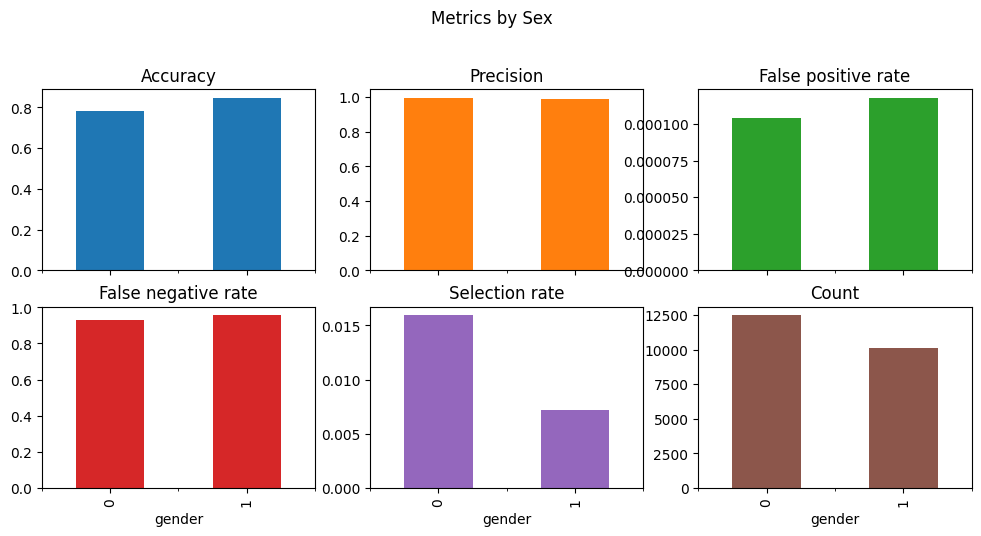

In [52]:
# Plot metrics using MetricFrame
xgb_metrics = {
    "Accuracy": accuracy_score,
    "Precision": partial(precision_score, zero_division=0), #precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

xgb_metric_frame = MetricFrame(
    metrics=xgb_metrics, y_true=y_test, y_pred=xgb_preds, sensitive_features=A_test
)

# Plotting
xgb_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [53]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
xgb_accuracy_values = xgb_metric_frame.by_group["Accuracy"]
xgb_acc_diff = xgb_accuracy_values.max() - xgb_accuracy_values.min()
print(f"Accuracy difference: {xgb_acc_diff:.4f}")

# Precision difference
xgb_precision_values = xgb_metric_frame.by_group["Precision"]
xgb_prec_diff = xgb_precision_values.max() - xgb_precision_values.min()
print(f"Precision difference: {xgb_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
xgb_tpr_values = 1 - xgb_metric_frame.by_group["False negative rate"]
xgb_tpr_diff = xgb_tpr_values.max() - xgb_tpr_values.min() 
print(f"True positive rate difference: {xgb_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
xgb_fpr_values = xgb_metric_frame.by_group["False positive rate"]
xgb_fpr_diff = xgb_fpr_values.max() - xgb_fpr_values.min()
print(f"False positive rate difference: {xgb_fpr_diff:.4f}")

# Demographic parity (DemP) difference
xgb_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=xgb_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {xgb_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
xgb_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=xgb_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {xgb_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0620
Precision difference: 0.0087
True positive rate difference: 0.0242
False positive rate difference: 0.0000
Demographic parity difference: 0.0087
Equalized odds difference: 0.0242


### MLP

array([[<Axes: title={'center': 'Accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'Precision'}, xlabel='gender'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Count'}, xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>,
        <Axes: xlabel='gender'>]], dtype=object)

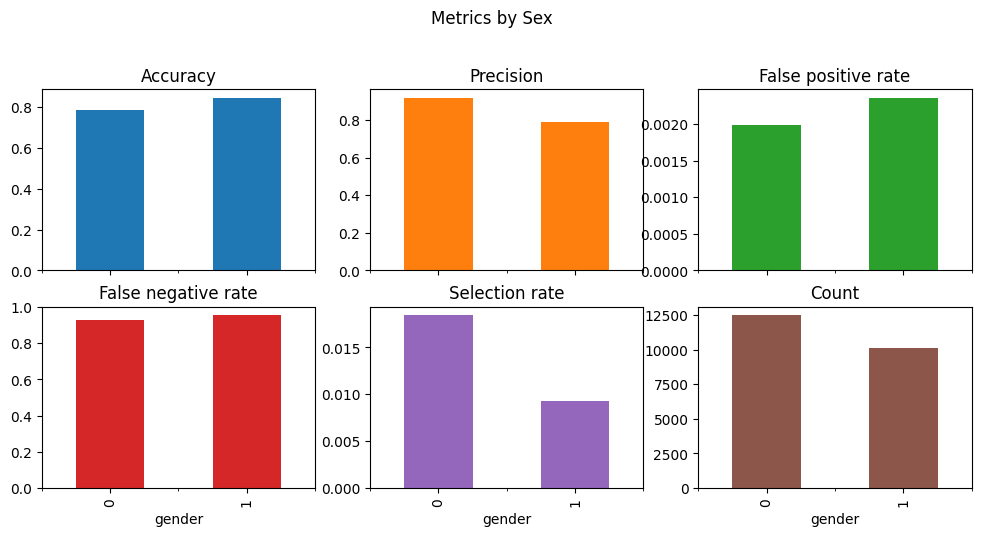

In [54]:
# Plot metrics using MetricFrame
mlp_metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

mlp_metric_frame = MetricFrame(
    metrics=mlp_metrics, y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test
)

# Plotting
mlp_metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [55]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
mlp_accuracy_values = mlp_metric_frame.by_group["Accuracy"]
mlp_acc_diff = mlp_accuracy_values.max() - mlp_accuracy_values.min()
print(f"Accuracy difference: {mlp_acc_diff:.4f}")

# Precision difference
mlp_precision_values = mlp_metric_frame.by_group["Precision"]
mlp_prec_diff = mlp_precision_values.max() - mlp_precision_values.min()
print(f"Precision difference: {mlp_prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_tpr_values = 1 - mlp_metric_frame.by_group["False negative rate"]
mlp_tpr_diff = mlp_tpr_values.max() - mlp_tpr_values.min() 
print(f"True positive rate difference: {mlp_tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
mlp_fpr_values = mlp_metric_frame.by_group["False positive rate"]
mlp_fpr_diff = mlp_fpr_values.max() - mlp_fpr_values.min()
print(f"False positive rate difference: {mlp_fpr_diff:.4f}")

# Demographic parity (DemP) difference
mlp_dp_diff = demographic_parity_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Demographic parity difference: {mlp_dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
mlp_eo_diff = equalized_odds_difference(y_true=y_test, y_pred=mlp_preds, sensitive_features=A_test)
print(f"Equalized odds difference: {mlp_eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0607
Precision difference: 0.1302
True positive rate difference: 0.0275
False positive rate difference: 0.0004
Demographic parity difference: 0.0091
Equalized odds difference: 0.0275


### TabResNet

array([[<Axes: title={'center': 'Accuracy'}, xlabel='gender'>,
        <Axes: title={'center': 'Precision'}, xlabel='gender'>,
        <Axes: title={'center': 'False positive rate'}, xlabel='gender'>],
       [<Axes: title={'center': 'False negative rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Selection rate'}, xlabel='gender'>,
        <Axes: title={'center': 'Count'}, xlabel='gender'>],
       [<Axes: xlabel='gender'>, <Axes: xlabel='gender'>,
        <Axes: xlabel='gender'>]], dtype=object)

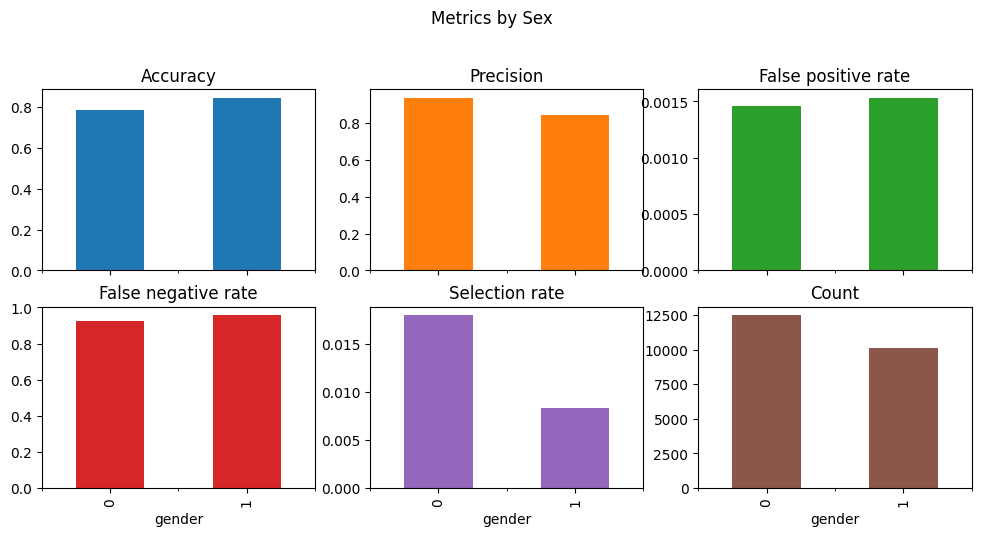

In [56]:
# Plot metrics using MetricFrame
metrics = {
    "Accuracy": accuracy_score,
    "Precision": precision_score,
    "False positive rate": false_positive_rate,
    "False negative rate": false_negative_rate,
    "Selection rate": selection_rate,
    "Count": count,
}

metric_frame = MetricFrame(
    metrics=metrics, y_true=y_test, y_pred=preds, sensitive_features=A_test
)

# Plotting
metric_frame.by_group.plot.bar(
    subplots=True,
    layout=[3, 3],
    legend=False,
    figsize=[12, 8],
    title="Metrics by Sex",
)

In [57]:
# Some "difference" metrics (as in Nils' paper)
display(Markdown("#### Raw values")) 

# Accuracy difference
accuracy_values = metric_frame.by_group["Accuracy"]
acc_diff = accuracy_values.max() - accuracy_values.min()
print(f"Accuracy difference: {acc_diff:.4f}")

# Precision difference
precision_values = metric_frame.by_group["Precision"]
prec_diff = precision_values.max() - precision_values.min()
print(f"Precision difference: {prec_diff:.4f}")

# True positive rate (TPR) difference
# tpr_diff = true_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
tpr_values = 1 - metric_frame.by_group["False negative rate"]
tpr_diff = tpr_values.max() - tpr_values.min() 
print(f"True positive rate difference: {tpr_diff:.4f}")

# False positive rate (FPR) difference
# fpr_diff = false_positive_rate_difference(y_true=y_test, y_pred=y_pred, sensitive_features=A_test) # still work but not seen in current version of fairlearn
fpr_values = metric_frame.by_group["False positive rate"]
fpr_diff = fpr_values.max() - fpr_values.min()
print(f"False positive rate difference: {fpr_diff:.4f}")

# Demographic parity (DemP) difference
dp_diff = demographic_parity_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Demographic parity difference: {dp_diff:.4f}")

# Equalized odds (EO) difference
# Defined as the greater of the 2 metrics: TPR difference and the FPR difference: max(tpr_diff, fpr_diff)
# Currently, this is the same as the TPR difference
eo_diff = equalized_odds_difference(y_true=y_test, y_pred=preds, sensitive_features=A_test)
print(f"Equalized odds difference: {eo_diff:.4f}")

#### Raw values

Accuracy difference: 0.0608
Precision difference: 0.0923
True positive rate difference: 0.0290
False positive rate difference: 0.0001
Demographic parity difference: 0.0096
Equalized odds difference: 0.0290
